# Explain linear models with categorical input features

In this tutorial, we discuss categorical features, how linear models handle them, and how to explain their contributions toward a given
prediction. We will critique the popular method of reporting a separate importance to each category of each feature. Instead, we will attribute
a single importance score per feature, regardless of the number of possible values can take.

## Fitting a Linear Model

In [1]:
import numpy as np
from pyfd.data import get_data_mushroom

X, y, features = get_data_mushroom()
print(X.shape)
print(y[:10])
features.summary()

(8124, 21)
[1 0 0 1 0 0 0 0 1 0]
|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | cap-shape          | nominal            | 6          | [0]              |
| 1 | cap-surface        | nominal            | 4          | [1]              |
| 2 | cap-color          | nominal            | 10         | [2]              |
| 3 | bruises            | nominal            | 2          | [3]              |
| 4 | odor               | nominal            | 9          | [4]              |
| 5 | gill-attachment    | nominal            | 2          | [5]              |
| 6 | gill-spacing       | nominal            | 2          | [6]              |
| 7 | gill-size          | nominal            | 2          | [7]              |
| 8 | gill-color         | nominal            | 12         | [8]              |
| 9 | stalk-shape        | nominal            | 2          | [9]              |
| 10| s

We investigate the [mushroom](https://archive.ics.uci.edu/dataset/73/mushroom) dataset, which aims at predicting whether a mushroom is poisonous ($y=1$) or edible ($y=0$) based on 21 categorical feature. A categorical 
feature is an attribute that can only take values from a finite set of (unordered) categories. 
Here are some examples from the mushroom dataset.

In [2]:
print(f"Feature {features.feature_objs[0].name} can take the values : {features.feature_objs[0].cats}")
print(f"Feature {features.feature_objs[1].name} can take the values : {features.feature_objs[1].cats}")
print(f"Feature {features.feature_objs[2].name} can take the values : {features.feature_objs[2].cats}")

Feature cap-shape can take the values : ['bell', 'conical', 'convex', 'flat', 'knobbed', 'sunken']
Feature cap-surface can take the values : ['fibrous', 'grooves', 'scaly', 'smooth']
Feature cap-color can take the values : ['brown', 'buff', 'cinnamon', 'gray', 'green', 'pink', 'purple', 'red', 'white', 'yellow']


In the data matrix `X`, these categorical features have already been encoded as integers.

In [3]:
print(X[:5, :3])

[[2. 3. 0.]
 [2. 3. 9.]
 [0. 3. 8.]
 [2. 2. 8.]
 [2. 3. 3.]]


When feature $\texttt{cap-color}$ (third column) takes the value $9$, its actual value is given by the ninth category : $\texttt{cap-color}=\texttt{yellow}$. Although it is convenient to represent categories as 
integers, doing so imposes an order relation because $0$ is smaller than $1$ which is smaller than $2$ etc. 
These orders are nonsensical : why should $\texttt{cap-shape}=\texttt{bell}$ be encoded as a smaller integer 
than $\texttt{cap-shape}=\texttt{conical}$?

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.96


The reported accuracy is good, although we could do better by using a One-Hot-Encoder. Such encoders work as follows : assuming feature $i$ can take $C$ possible values, the observation $x_i=c$ is encoded as a vector of dimension $C$ whose components are all zero, except for $c^{\text{th}}$ component, whose value is $1$. 

$$ x_i = 0 \Rightarrow [1, 0, 0, 0]$$
$$ x_i = 1 \Rightarrow [0, 1, 0, 0]$$
$$ x_i = 2 \Rightarrow [0, 0, 1, 0]$$
$$ x_i = 3 \Rightarrow [0, 0, 0, 1]$$

This procedure has the advantage of not imposing an order between the different categories of $x_i$.

In [8]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
# We use the whole dataset for the OHE. There is no data leakage since the encoder
# does not see the labels. We do this to avoid issues where the test set contains
# categories that were not seen during training.
ohe.fit_transform(X)
X_encoded_train = ohe.transform(X_train)
X_encoded_test = ohe.transform(X_test)
# The one-hot-encoded matrix has a lot more than 21 columns
print(X_encoded_train.shape)

(6499, 116)


In [16]:
# The first 4 instances of the feature 0
print(X_train[:4, [0]])
# The corresponding one-hot-encoded values
print(X_encoded_train[:4, :6].toarray())

[[4.]
 [2.]
 [3.]
 [3.]]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [17]:
# The first 4 instances of the feature 1
print(X_train[:4, [1]])
# The corresponding one-hot-encoded values
print(X_encoded_train[:4, 6:10].toarray())

[[3.]
 [3.]
 [2.]
 [0.]]
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


We fit a linear model on this augmented data matrix and obtain perfect test accuracy.

In [18]:
model = LogisticRegression(max_iter=1000, random_state=42).fit(X_encoded_train, y_train)
print(model.score(X_encoded_test, y_test))

1.0


## Explaining the Linear Model

It is extremelly common to explain linear models by reporting the magnitude of their weights
(or coefficients). When one-hot-encoded features are used, there is a distinct weight $\omega_i$
for each category of each feature.

In [8]:
def print_categories_and_coefs(model, features):
    feature_names = features.names()
    weights = model.coef_[0]
    counter = 0
    for i, feature_obj in enumerate(features.feature_objs):
        for category in feature_obj.cats[1:]:
            full_name = "-".join([feature_names[i], category])
            print(f"{full_name} : {weights[counter]:.2f}")
            counter += 1
print_categories_and_coefs(model, features) 

cap-shape-conical : 0.38
cap-shape-convex : 0.47
cap-shape-flat : -0.14
cap-shape-knobbed : -0.06
cap-shape-sunken : 0.01
cap-surface-grooves : -0.60
cap-surface-scaly : -0.82
cap-surface-smooth : 0.63
cap-color-buff : -0.03
cap-color-cinnamon : 0.28
cap-color-gray : -0.30
cap-color-green : 0.98
cap-color-pink : -1.06
cap-color-purple : 0.10
cap-color-red : -0.40
cap-color-white : 0.83
cap-color-yellow : -0.45
bruises-no : 0.08
odor-anise : 0.53
odor-creosote : -0.25
odor-fishy : 0.07
odor-foul : -0.01
odor-musty : -2.63
odor-none : -2.64
odor-pungent : 2.56
odor-spicy : 0.78
gill-attachment-free : 2.77
gill-spacing-crowded : 0.34
gill-size-narrow : -3.96
gill-color-brown : 2.07
gill-color-buff : 0.78
gill-color-chocolate : -0.11
gill-color-gray : 0.17
gill-color-green : 1.64
gill-color-orange : -1.58
gill-color-pink : -2.22
gill-color-purple : 2.29
gill-color-red : -0.47
gill-color-white : -0.63
gill-color-yellow : 1.89
stalk-shape-tapering : 0.09
stalk-root-club : -0.03
stalk-root-eq

That is a lot of coefficients to report and interpret! What should you do if you want to get some insight on how your model works without looking at each individual coefficients? Ideally, we would want a separate importance score for each 21 feature (instead of each 116 category). This would highlight which mushroom characteristics (color, smell) are most common in poisonous species.

To compute a distinct importance score for each feature $x_i$, we must write the linear model in a different 
form. Letting $\mathbf{1}(\cdot)$ be an indicator function 
$$\mathbf{1}(\text{statement})=
   \begin{cases}
         1 & \text{if statement is true}\\
         0 & \text{otherwise},
   \end{cases}
$$
a linear model fitted on one-hot-encoded features can be written

$$ h(x) = \omega_0 + \omega_1 \mathbf{1}(x_1=a) + \omega_2 \mathbf{1}(x_1=b) + \omega_3 \mathbf{1}(x_2=c) + \omega_4 \mathbf{1}(x_2=d) + \omega_5 \mathbf{1}(x_2=e) + \ldots$$

This is nothing more than an **additive** model in disguise

$$h(x) = \omega_0 + h_1(x_1) + h_2(x_2) + \ldots$$

Remember that we know how to explain such models

$$\text{Importance of feature } i = h_i(x_i) - \mathbb{E}_{z\sim\mathcal{B}}[h_i(z_i)],$$

so we can use `PyFD` to compute rigorous feature importance scores.

In [19]:
from sklearn.pipeline import Pipeline

# To use PyFD, it is necessary to have the OHE be part of a Pipeline. This will allow to package to
# determine which one-hot-encoded columns correspond to which feature x_i.
# Also, we pass `drop="first"` to `OneHotEncoder` to save memory.
model = Pipeline([('encoder', OneHotEncoder(drop="first")), 
                  ('predictor', LogisticRegression(max_iter=1000, random_state=42))])
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0

In [20]:
from pyfd.decompositions import get_components_linear
from pyfd.plots import partial_dependence_plot, bar

foreground = X
background = X
# We use the get_components_linear like in previous tutorials on linear models
decomp = get_components_linear(model, foreground, background, features)
print(decomp.keys())
print(decomp[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,)])
(8124,)


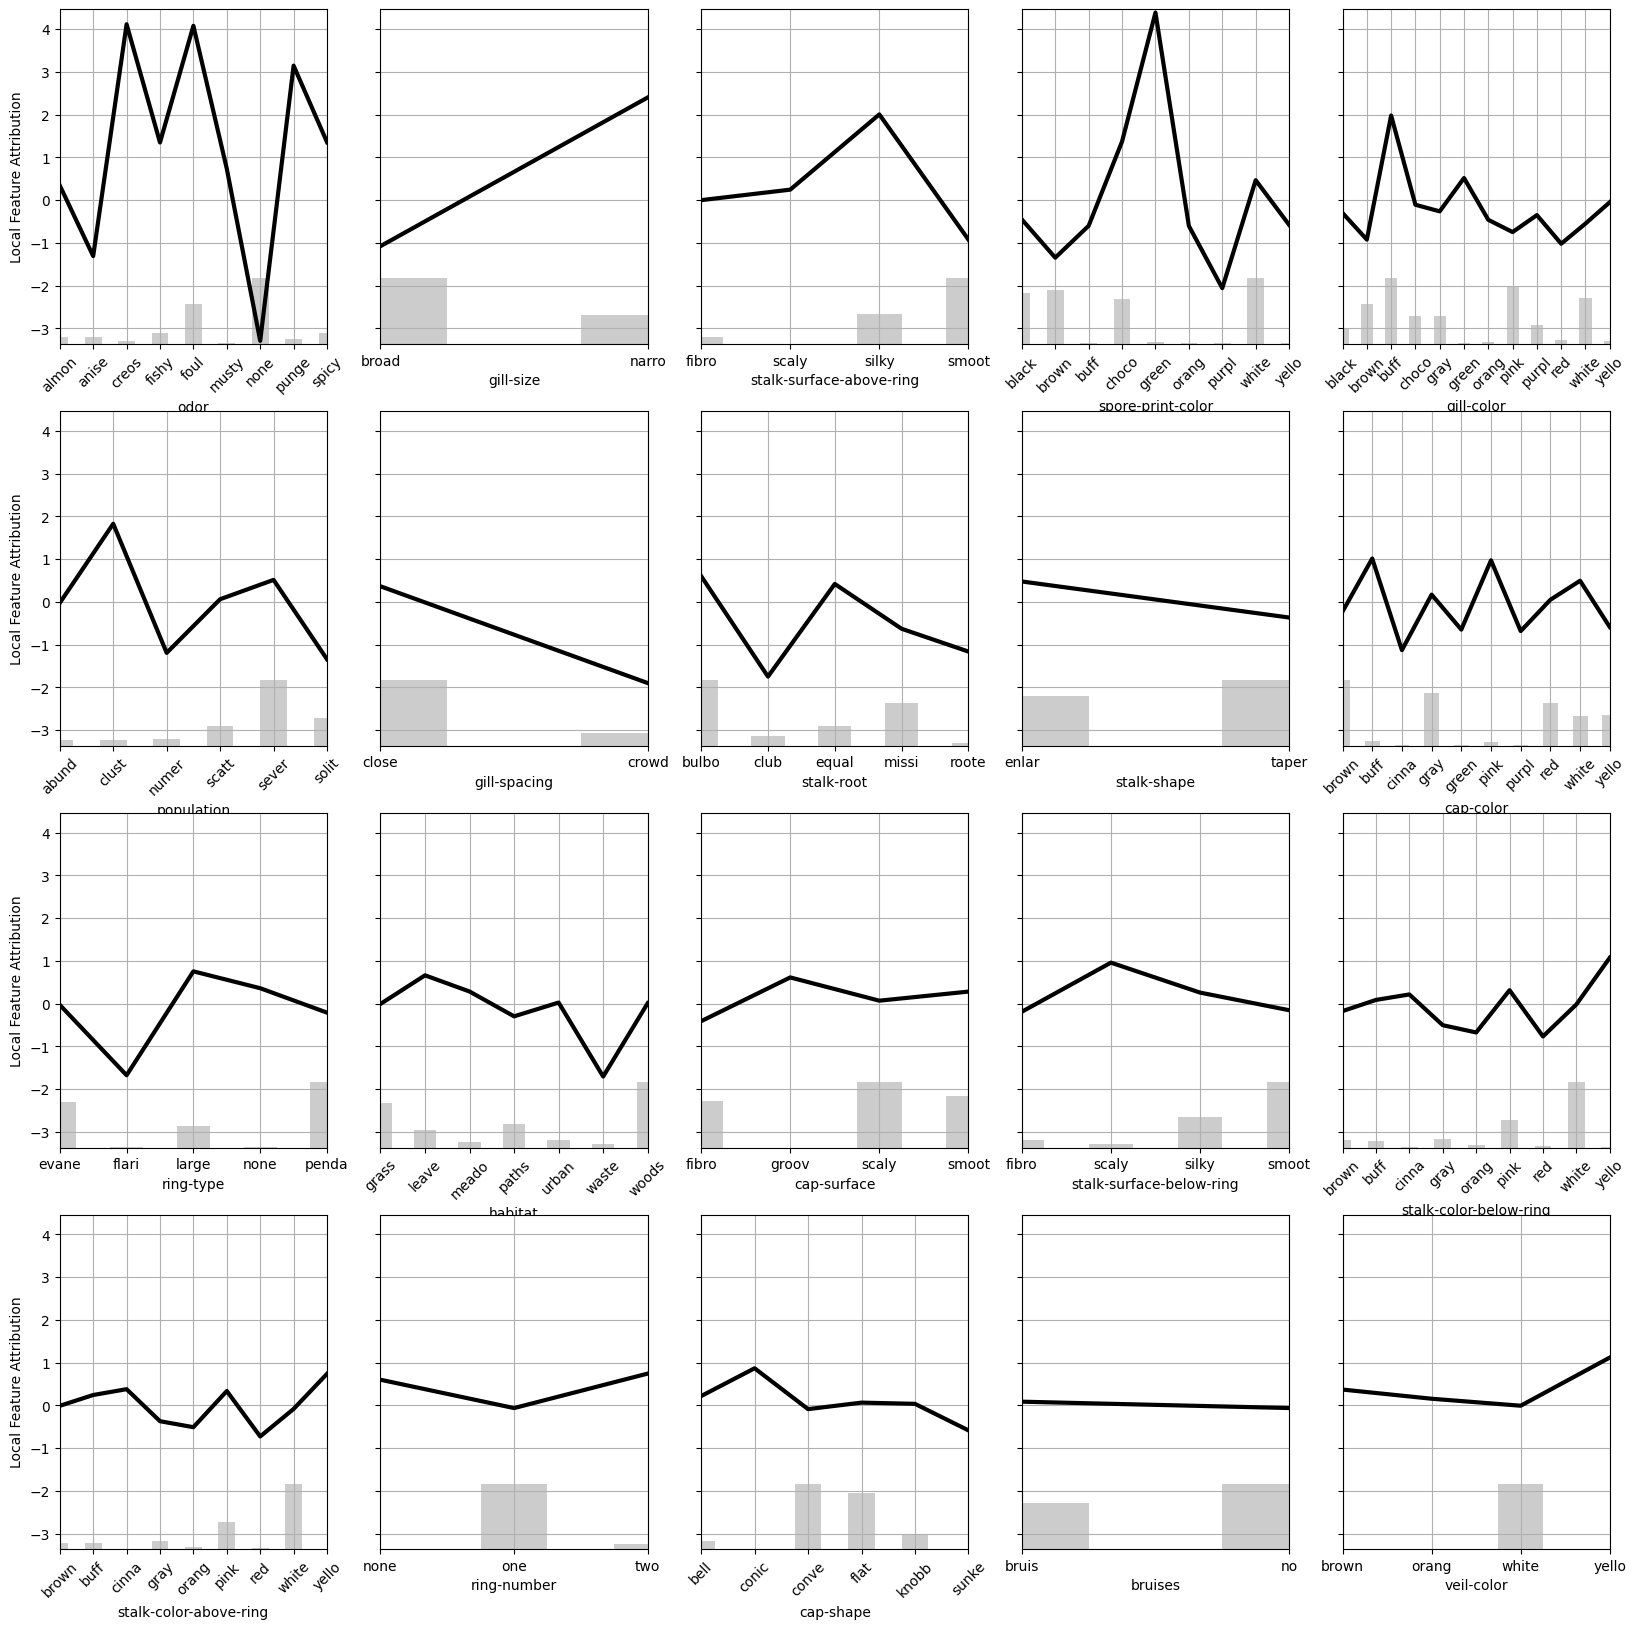

In [21]:
partial_dependence_plot(decomp, foreground, features, idxs=20, n_cols=5, cat_name_threshold=5, figsize=(20, 20))

To understand individual model predictions, feature importance can be plotted as bars.

##### Instance 0 #####


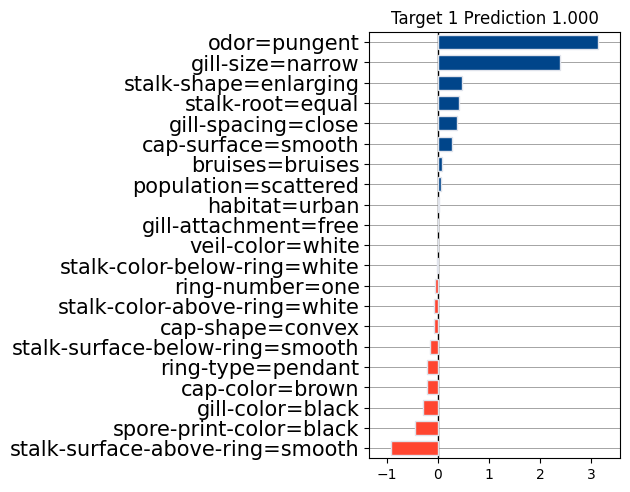

##### Instance 1 #####


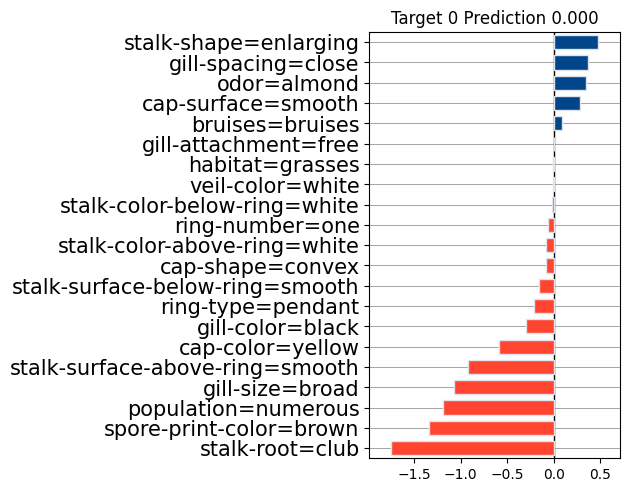

In [22]:
import matplotlib.pyplot as plt

for idx in [0, 1]:
    print(f"##### Instance {idx} #####")
    # Choose an instance
    x_explain = X[[idx]]
    x_map = features.print_value(x_explain.ravel())

    # Predictions and explanation
    pred = model.predict(x_explain)
    bar(np.array([decomp[(i,)][idx] for i in range(len(features))]), x_map)
    plt.title(f"Target {y[idx]} Prediction {pred[0]:.3f}")
    plt.show()

You can also aggregate local feature importance values to attribute a **global** importance to each feature.

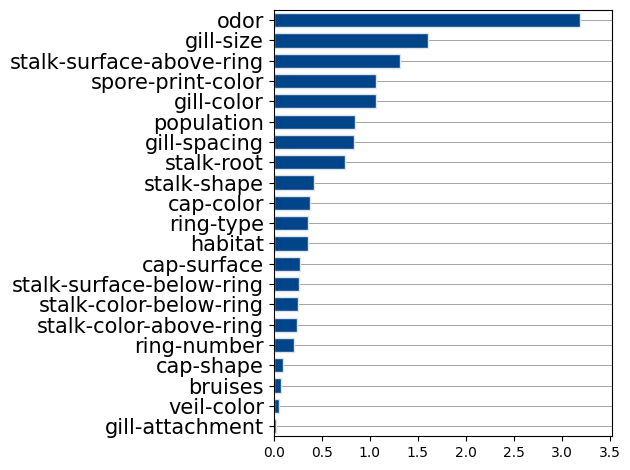

In [23]:
GFI = np.stack([(decomp[(i,)]**2).mean() for i in range(len(features))])
GFI = np.sqrt(GFI)
features_names = features.names()
bar(GFI, features_names)
plt.show()

The two most importance features for identifying poisonous mushrooms are their odor and gill-size.

## Feature Selection

By reporting a single importance score per feature, we were able to significantly reduce the verbosity of 
the model explanations (from 116 importance scores to 21). Still, the model uses too many features to be considered interpretable in my opinion. `PyFD` solves this issue by removing features with a low global importance.

In [24]:
# This function removes all features with an importance lower than the threshold
# and reports the test accuracy of the resulting model.
def remove_feature_and_retrain(threshold):
    # Remove features with low importance
    remove_features_idx = np.where(GFI < threshold)[0]
    X_trimmed = np.delete(X, remove_features_idx, axis=1)
    # Resplit the data
    X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y, test_size=0.2, random_state=42)
    # Train a new model on trimmed data
    model_trimmed = Pipeline([('encoder', OneHotEncoder(drop="first")), 
                              ('predictor', LogisticRegression(max_iter=1000, random_state=42))])
    model_trimmed.fit(X_train, y_train)
    return model_trimmed.score(X_test, y_test)

In [25]:
for threshold in np.linspace(0.1, 2.5, 10):
    print(f"Treshold {threshold:.2f} : Acc {remove_feature_and_retrain(threshold)}")

Treshold 0.10 : Acc 1.0
Treshold 0.37 : Acc 0.9993846153846154
Treshold 0.63 : Acc 0.9993846153846154
Treshold 0.90 : Acc 0.9993846153846154
Treshold 1.17 : Acc 0.9907692307692307
Treshold 1.43 : Acc 0.9846153846153847
Treshold 1.70 : Acc 0.9846153846153847
Treshold 1.97 : Acc 0.9846153846153847
Treshold 2.23 : Acc 0.9846153846153847
Treshold 2.50 : Acc 0.9846153846153847


In [26]:
# By chossing the 0.9 threshold, we have a model with an equivalent perf (99.9%), but
# that uses significantly less features.
remove_features_idx = np.where(GFI < 0.9)[0]
X_trimmed = np.delete(X, remove_features_idx, axis=1)
print(X_trimmed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y, test_size=0.2, random_state=42)
model_trimmed = Pipeline([('encoder', OneHotEncoder(drop="first")), 
                          ('predictor', LogisticRegression(max_iter=1000, random_state=42))])
model_trimmed.fit(X_train, y_train)

(8124, 5)


Pipeline(steps=[('encoder', OneHotEncoder(drop='first')),
                ('predictor',
                 LogisticRegression(max_iter=1000, random_state=42))])

The `features` object must be altered to take into acount the fact that we removed most columns from `X`.

In [27]:
features_trimmed = features.remove(remove_features_idx)
features_trimmed.summary()

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | odor               | nominal            | 9          | [4]              |
| 1 | gill-size          | nominal            | 2          | [7]              |
| 2 | gill-color         | nominal            | 12         | [8]              |
| 3 | stalk-surface-above| nominal            | 4          | [11]             |
| 4 | spore-print-color  | nominal            | 9          | [18]             |
-------------------------------------------------------------------------------



The `Groups` column indicates what column of `X` a given feature relates to. Importantly, since the matrix `X` 
has been trimmed into `X_trimmed`, we need to call the `.reset_Imap_inv()` method.

In [28]:
features_trimmed = features_trimmed.reset_Imap_inv()
features_trimmed.summary()

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | odor               | nominal            | 9          | [0]              |
| 1 | gill-size          | nominal            | 2          | [1]              |
| 2 | gill-color         | nominal            | 12         | [2]              |
| 3 | stalk-surface-above| nominal            | 4          | [3]              |
| 4 | spore-print-color  | nominal            | 9          | [4]              |
-------------------------------------------------------------------------------



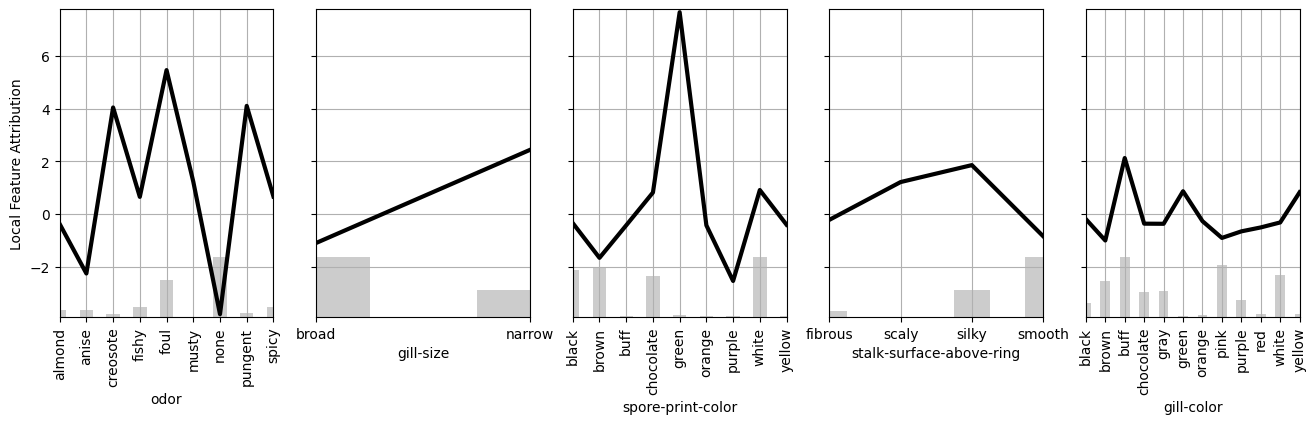

In [29]:
foreground = X_trimmed
background = X_trimmed
decomp = get_components_linear(model_trimmed, foreground, background, features_trimmed)
partial_dependence_plot(decomp, foreground, features_trimmed, figsize=(16, 4))

I am not mushroom expert but this plot allows me to get some insight
- Do not consume mushrooms that have a creosote, foul or pungent `odor`.
- Avoid mushrooms with a narrow `gill-size`.
- Never eat mushrooms with a green `spore-print-color`.